## Семинар 2 "Распознавание рукописных цифр"

ФИО:

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
%matplotlib inline

In [2]:
from scipy.linalg import sqrtm
from scipy.linalg import inv

In [3]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

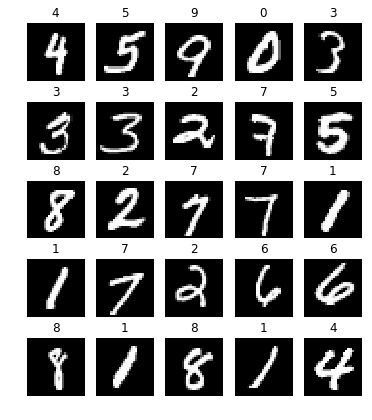

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
class Linear:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        #np.random.seed(seed=1234)
        self.weights = np.random.normal(0, 1, (input_size + 1, output_size))
        self.dLdw = 0
        self.X = 0
        
        return
    
    def forward(self, X):
        self.X = X
        
        return np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.weights)
    
    def backward(self, dLdy):
        dLdx = np.dot(dLdy, self.weights[:len(self.weights) - 1].T)  
        self.dLdw = np.dot(np.vstack((self.X.T, np.ones(self.X.shape[0]))), dLdy)        
        return dLdx
    
    def step(self, learning_rate):
        self.weights = self.weights + self.dLdw * learning_rate

class Sigmoid:
    def __init__(self):
        self.X = np.array([])
    
    def forward(self, X):
        self.X = X        
        res = np.nan_to_num(1.0 / (1.0 + np.nan_to_num(np.exp(-1 * X))))
        return res
    
    def backward(self, dLdy):
        m = np.nan_to_num(np.exp(self.X))
        res = m / (m + 1.0)
        res /= (m + 1.0)
        res = dLdy * res
        return res
    
    def step(self, learning_rate):
        pass

class RELU:
    def __init__(self):
        self.X = np.array([])
    
    def forward(self, X):
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        return dLdy * (self.X > 0)
    
    def step(self, learning_rate):
        pass

class ELU:
    def __init__(self):
        self.X = np.array([])
        self.alpha = 0.5
        
    def forward(self, X):
        self.X = X    
        I = (self.X < 0)
        l = self.alpha * (np.exp(X * I) - 1) * I
        r = X * (X >= 0)        
        return l + r

    def backward(self, dLdy):
        I = (self.X < 0)
        l = (self.alpha * (np.exp(self.X * I) - 1) + self.alpha) * I
        r = 1.0 * (self.X >= 0)
        return dLdy * (l + r)
    
    def step(self, learning_rate):
        pass
    
class NLLLoss:
    def __init__(self):
        self.X = np.array([])
        self.y = np.array([])
    
    def forward(self, X, y):
        self.X = X
        self.y = y
        r = np.exp(X - X.max(axis=1).reshape((X.shape[0], 1))).sum(axis=1)
        res = (np.array([X[i][y[i]] for i in range(y.shape[0])]) - X.max(axis=1) - np.log(r)).sum() / X.shape[0]
        
        return res
    
    def backward(self):
        res = np.exp(self.X - self.X.max(axis=1).reshape((self.X.shape[0], 1)))
        res /= res.sum(axis=1).reshape(res.shape[0], 1)     
        res *= -1.0
        for i in range(self.y.shape[0]):
            res[i][self.y[i]] += 1
        
        return res / self.X.shape[0]
    
class NeuralNetwork:
    def __init__(self, modules):
        self.modules = modules
    
    def forward(self, X):
        res = X
        for module in self.modules:
            res = module.forward(res)
        return res
    
    def backward(self, dLdy):
        d = dLdy
        for module in self.modules[::-1]:
            d = module.backward(d)
    
    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)

In [32]:
def emulate(N, data, stepAlpha, neuralNetwork, nllLoss, covar, expectations):
    losses = np.zeros(N)
    if covar.shape[0] != 0:
        Z = np.real(sqrtm(covar + np.eye(covar.shape[0]) * 0.01))
        Z = inv(Z + np.eye(covar.shape[0]))

    for j in range(N):
        tl = 0
        for X, y in data:            
            X = X.view(X.size(0), -1)
            X = X.numpy()
            y = y.numpy()
            
            if covar.shape[0] != 0:
                X = X - expectation.reshape((1, X.shape[1]))
                X = np.dot(X, Z)
                
            res = neuralNetwork.forward(X)
            loss = nllLoss.forward(res, y)
            neuralNetwork.backward(nllLoss.backward())
            neuralNetwork.step(stepAlpha)
            if abs(loss) > abs(tl):
                tl = loss
        print('Epoch ' + str(j) + ' finished')
        losses[j] = tl
    return losses

In [8]:
def predict(data, neuralNetwork, nllLoss, covar, expectations):
    tl = 0
    if covar.shape[0] != 0:
        Z = np.real(sqrtm(covar + np.eye(covar.shape[0]) * 0.01))
        Z = inv(Z + np.eye(covar.shape[0]))
    for X, y in data:
        X = X.view(X.size(0), -1)
        X = X.numpy()
        y = y.numpy()
        
        if (covar.shape[0] != 0):
            X = X - expectation.reshape((1, X.shape[1]))
            X = np.dot(X, Z)
        
        res = neuralNetwork.forward(X)
        loss = nllLoss.forward(res, y)
        if abs(loss) > abs(tl):
            tl = loss
    return tl

In [101]:
m = [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)]
nll = NLLLoss()
nn = NeuralNetwork(m)

In [102]:
losses = emulate(30, train_loader, 1, nn, nll, np.empty(0), np.empty(0))

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


In [103]:
losses.max()

-0.26279114835572859

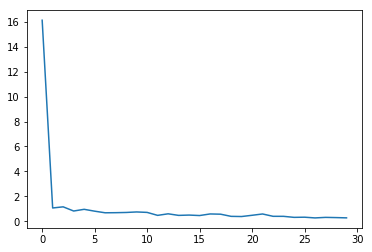

In [104]:
plt.plot([i for i in range(len(losses))], -1 * losses)

In [114]:
predict(test_loader, nn, nll, np.empty(0), np.empty(0))

-1.0399708364326172

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [65]:
m2 = [Linear(784, 100), RELU(), Linear(100, 100), RELU(), Linear(100, 10)]
nll2 = NLLLoss()
nn2 = NeuralNetwork(m2)

In [66]:
losses2 = emulate(10, train_loader, 0.9, nn2, nll2, np.empty(0), np.empty(0))

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished


In [67]:
losses2.max()

-2.3899647112912406

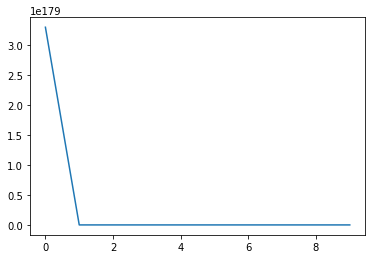

In [68]:
plt.plot([i for i in range(len(losses2))], -1 * losses2)

In [22]:
m3 = [Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10)]
nll3 = NLLLoss()
nn3 = NeuralNetwork(m3)

In [23]:
losses3 = emulate(10, train_loader, 0.001, nn3, nll3, np.empty(0), np.empty(0))

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished


In [24]:
losses3.max()

-12.755380082197739

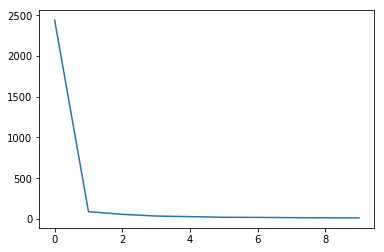

In [25]:
plt.plot([i for i in range(len(losses3))], -1 * losses3)

### Часть 3: Предобработка данных

Посчитайте на всей обучающей выборке матрицу ковариации и среднее. Нормализуйте данные по схеме: вычесть среднее, декоррелировать, нормировать дисперсию. Сравните графики обучения на одной и той же архитектуре с и без предобработки.

In [26]:
D = np.empty(0)
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy()
    
    if (len(D) == 0):
        D = X
    else:
        D = np.vstack((D, X))
    
    if (D.shape[0] > 1000):
        break
cov = np.dot(D.T, D) * (1.0 / D.shape[0])
expectation = D.mean(axis=0)

In [106]:
m4 = [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)]
nll4 = NLLLoss()
nn4 = NeuralNetwork(m4)

In [107]:
losses4 = emulate(30, train_loader, 1, nn4, nll4, cov, expectation)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


In [112]:
losses4.max()

-0.1282669602983072

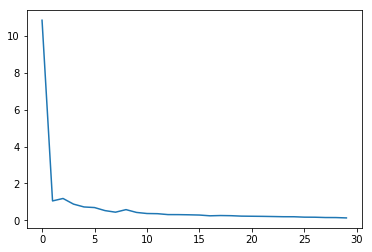

In [109]:
plt.plot([i for i in range(len(losses4))], -1 * losses4)

In [113]:
predict(test_loader, nn4, nll4, cov, expectation)

-1.72915517366741

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

ReLu и ELU сходятся намного хуже по сравнению с сигмоидой и итоговое качество плохое.

Нормализация данных немного ускоряет сходимость в данном случае, по сравнению с сигмоидой,
но качество на тестовых данных ухудшается тоже быстрее.